# Forecasting Real Estate Value in San Jose, CA


### Lynn Anderson


# Overview

The aim of this project was to use time Series analysis to build a model that predicts the future real estate  values of zip codes in the San Jose, CA metro area. Specifically, I sought to identify which zipcodes are forecasted to provide the highest return on investment in the next 3 years. I investigated the performance of a SARIMAX model and Prophet model on one zipocde, and subsequently selected the higher performing model to forecast future real estate values on all relevant zipcodes.


# Business Understanding

Bay Area Properties Group is looking to invest in real estate in the San Jose area. Many tech start ups are based in this location, and, with an influx of high-income tech workers, there is lkely to be a demand for property in the future. To give enough time to allow values to appreciate, yet minimize risks that come with uncertainty of trying to predict far into the future, they are initially looking for 3 year investments. Therefore, in order to make informed decisions, they want to know the 5 zipcodes predicted to provide the highest 3 year return on investment. Additionally, they are mindful of their starting budget, and are most interested in areas whose average priceis under 2 million.


# Data Understanding

The dataset consisted of a csv file obtained from Zillow Housing dataset. Each record represented a zipcode, with information including the city, metro area, county and state, as well as the average sale price of real estate taken at one month intervals. The original dataset consisted of records from 14,723 zip codes across all 50 states and DC, and spanned April 1996- April 2018. The data used in this project only looked at zip codes in the San Jose metro area. Additionally, to minimize the effects of the 2008 crash and model for more recent trends, only data from 2012 onwards was used for modeling.



# Data Preparation

I loaded the csv file into a dataframe and removed all unnecessary columns before investigating some basic statistical info. Additionally, the %ROI was calculated for each zipcode and added to the dataframe. In this analysis, 40 zipcodes in the San Jose area will be evaluated. 3 are in San Benito county, and the remaining in Santa Clara county. Average price for all zipcodes in April 2018 was $1.16 million, and average ROI was 127%. 

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima as pm
from pmdarima.arima import auto_arima
import math
from prophet import Prophet
import folium

warnings.simplefilter("ignore", ConvergenceWarning)
%matplotlib inline

#### Reshape dataframe from wide to long format

In [2]:
#"""Takes a dataframe in wide form or a subset of the zillow_dataset and returns a long-form datetime dataframe"""
def melt_data(df):
    
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', '%ROI', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [3]:
# load csv file into dataframe and preview
df = pd.read_csv("data/zillow_data.csv")
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [4]:
# number of records by state
df["State"].value_counts()

CA    1224
NY    1015
TX     989
PA     831
FL     785
OH     588
IL     547
NJ     502
MI     499
IN     428
NC     428
MA     417
TN     404
VA     401
MN     375
GA     345
WA     341
WI     332
MO     319
MD     317
CO     249
KS     241
AZ     230
OR     224
OK     221
SC     206
NH     199
LA     193
AL     183
IA     158
MS     153
KY     139
CT     124
UT     121
ID     110
AR     105
NV     103
ME      86
NE      83
WV      72
MT      71
HI      62
NM      60
RI      59
DE      41
ND      31
WY      31
AK      28
SD      19
DC      18
VT      16
Name: State, dtype: int64

In [5]:
df['State'].nunique()

51

In [6]:
# number of zipcodes
df['RegionName'].nunique()

14723

### Filtering the dataframe for San Jose, CA

In [7]:
# filter for relevant records
san_jose = df.loc[(df['Metro'] == 'San Jose')]
san_jose.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
244,97991,95123,San Jose,CA,San Jose,Santa Clara,245,224500.0,224800.0,225200.0,...,879400,894700,911900,931300,951900,970700,986100,1002200,1025400,1043900
289,97952,95051,Santa Clara,CA,San Jose,Santa Clara,290,258700.0,259300.0,259900.0,...,1252800,1287100,1326800,1365400,1405600,1444500,1476800,1508100,1547700,1577100
363,97940,95035,Milpitas,CA,San Jose,Santa Clara,364,231100.0,232100.0,233100.0,...,970900,982600,1000200,1021900,1045000,1063700,1076600,1096500,1131900,1160700
461,97926,95014,Cupertino,CA,San Jose,Santa Clara,462,432400.0,434500.0,436700.0,...,2099800,2135500,2181900,2235300,2291500,2336900,2374400,2416300,2464200,2490200
513,97980,95112,San Jose,CA,San Jose,Santa Clara,514,186800.0,186800.0,186700.0,...,738000,754200,772700,791600,812500,834100,852200,871200,896300,916100


In [8]:
# observe price stats for April 2018
san_jose['2018-04'].describe()

count    5.500000e+01
mean     1.661938e+06
std      9.639275e+05
min      5.096000e+05
25%      1.045750e+06
50%      1.368000e+06
75%      2.092800e+06
max      4.818400e+06
Name: 2018-04, dtype: float64

The mean selling price for all of the San Jose metro area in April 2018 was \\$1.36 million, with the middle 50 percent falling between \\$1 and \\$2 million. 

### Filter to remove locations above $2,000,000

In [9]:
san_jose = san_jose[san_jose['2018-04']<=2e6]
san_jose.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
244,97991,95123,San Jose,CA,San Jose,Santa Clara,245,224500.0,224800.0,225200.0,...,879400,894700,911900,931300,951900,970700,986100,1002200,1025400,1043900
289,97952,95051,Santa Clara,CA,San Jose,Santa Clara,290,258700.0,259300.0,259900.0,...,1252800,1287100,1326800,1365400,1405600,1444500,1476800,1508100,1547700,1577100
363,97940,95035,Milpitas,CA,San Jose,Santa Clara,364,231100.0,232100.0,233100.0,...,970900,982600,1000200,1021900,1045000,1063700,1076600,1096500,1131900,1160700
513,97980,95112,San Jose,CA,San Jose,Santa Clara,514,186800.0,186800.0,186700.0,...,738000,754200,772700,791600,812500,834100,852200,871200,896300,916100
536,97993,95125,San Jose,CA,San Jose,Santa Clara,537,286000.0,287700.0,289600.0,...,1255400,1273600,1296800,1324600,1355000,1380100,1399800,1422600,1451000,1468100


In [10]:
san_jose.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40 entries, 244 to 11894
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 85.3+ KB


The filtered dataframe contains records for 40 zipcodes

In [11]:
# statistics for April 2018 prices
san_jose['2018-04'].describe()

count    4.000000e+01
mean     1.165880e+06
std      3.267753e+05
min      5.096000e+05
25%      9.102500e+05
50%      1.165400e+06
75%      1.447325e+06
max      1.926800e+06
Name: 2018-04, dtype: float64

The mean selling price is now \\$1.16 million, with the middle 50 percent falling between \\$910,000 and \\$1.4 million. 

In [12]:
# observe counties
san_jose['CountyName'].value_counts()

Santa Clara    37
San Benito      3
Name: CountyName, dtype: int64

In [13]:
# number of cities
san_jose['City'].nunique()

12

In [14]:
# number of records per city
san_jose['City'].value_counts()

San Jose             26
Santa Clara           3
Sunnyvale             2
Milpitas              1
Campbell              1
Gilroy                1
Morgan Hill           1
Hollister             1
Lexington Hills       1
San Martin            1
San Juan Bautista     1
Aromas                1
Name: City, dtype: int64

Most zipcodes fall into the city of San Jose, with a few in Santa Clara. All other cities have only one zipcode represented.

In [15]:
# zipcodes in the dataset
san_jose['RegionName'].value_counts()

95123    1
95051    1
95148    1
95118    1
95117    1
95121    1
95131    1
95133    1
95054    1
94089    1
95135    1
95110    1
95138    1
95130    1
95033    1
95119    1
95046    1
95139    1
95045    1
95132    1
95122    1
95120    1
95037    1
95035    1
95112    1
95125    1
94086    1
95008    1
95020    1
95124    1
95136    1
95116    1
95127    1
95111    1
95023    1
95050    1
95126    1
95128    1
95134    1
95004    1
Name: RegionName, dtype: int64

In [16]:
# check for duplicate entries
san_jose.duplicated().sum()

0

In [17]:
# check for null values
san_jose.isnull().sum().sum()

0

There are no duplicate entries or null values to deal with.

### Calculate percent ROI for each zipcode and add to dataframe

In [18]:
# add %ROI to the dataframe
san_jose["%ROI"] = ((san_jose["2018-04"] - san_jose["2012-01"]) / san_jose["2012-01"]) * 100

san_jose["%ROI"].head()

244    122.485081
289    160.290477
363    134.106495
513    164.386724
536    118.175063
Name: %ROI, dtype: float64

In [19]:
# order zipcodes by %ROI and preview top 5
san_jose.sort_values("%ROI",ascending=False)['RegionName'].head()

5328    94089
582     94086
513     95112
1856    95050
289     95051
Name: RegionName, dtype: int64

The zipcode with the highest return on investment from 2012-2018 is 94089

In [20]:
san_jose['%ROI'].describe()

count     40.000000
mean     127.125299
std       28.789601
min       62.874569
25%      114.411027
50%      129.909187
75%      143.458294
max      203.242021
Name: %ROI, dtype: float64

Mean ROI was 129%.

# Data Visualization

### ROI by zipcode

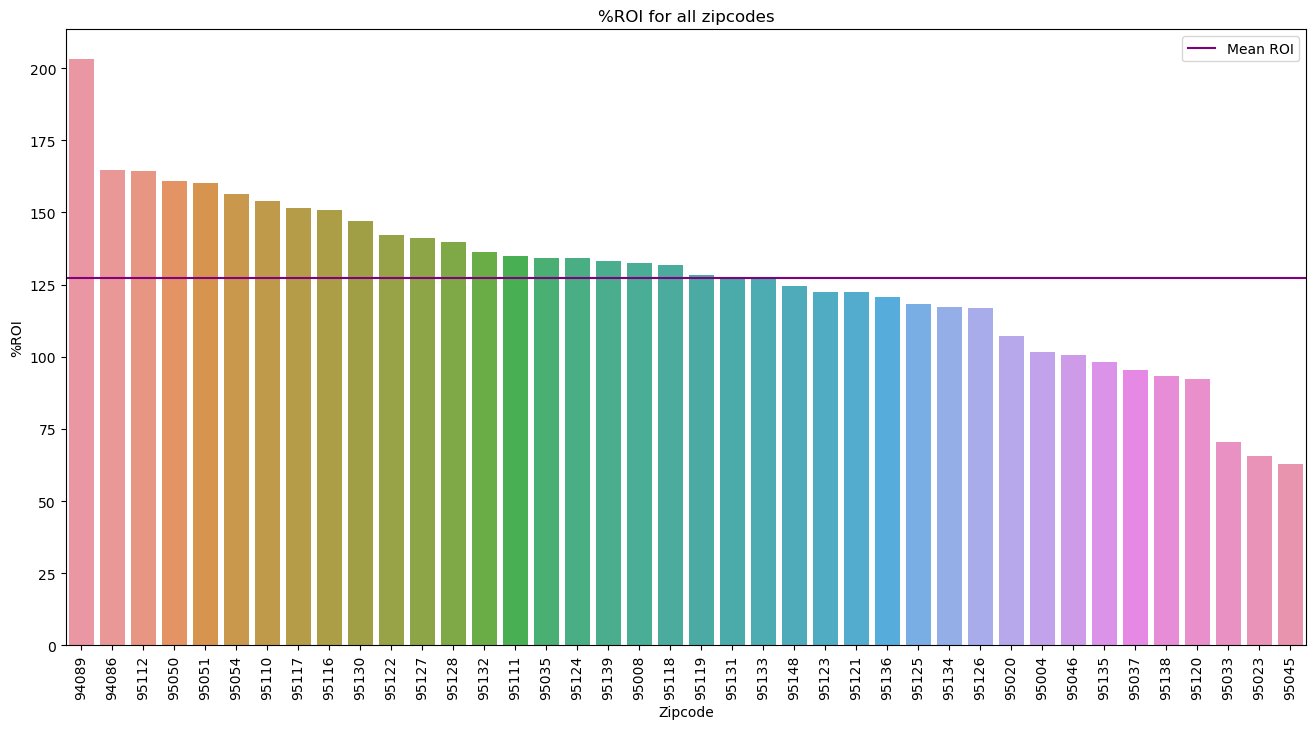

In [21]:
# plot each zipcode by %ROI
fig, ax = plt.subplots(figsize=(16, 8))
graph = sns.barplot(x='RegionName', y='%ROI', data=san_jose, 
                    order=san_jose.sort_values('%ROI', ascending = False).RegionName, ax=ax)
graph.axhline(san_jose['%ROI'].mean(), color='purple', label='Mean ROI')

ax.set_title('%ROI for all zipcodes')
ax.set_ylabel('%ROI')
ax.set_xlabel('Zipcode')
x_labels = [str(a) for a in san_jose.sort_values('%ROI', ascending = False).RegionName]
ax.set_xticklabels(x_labels, rotation = 90)
ax.legend(loc='best');

94089 was the highest growing zipcode by a substantial amount. Roughly half the zipcodes fall above the mean, and half below it. 

### Home value for each zipcode

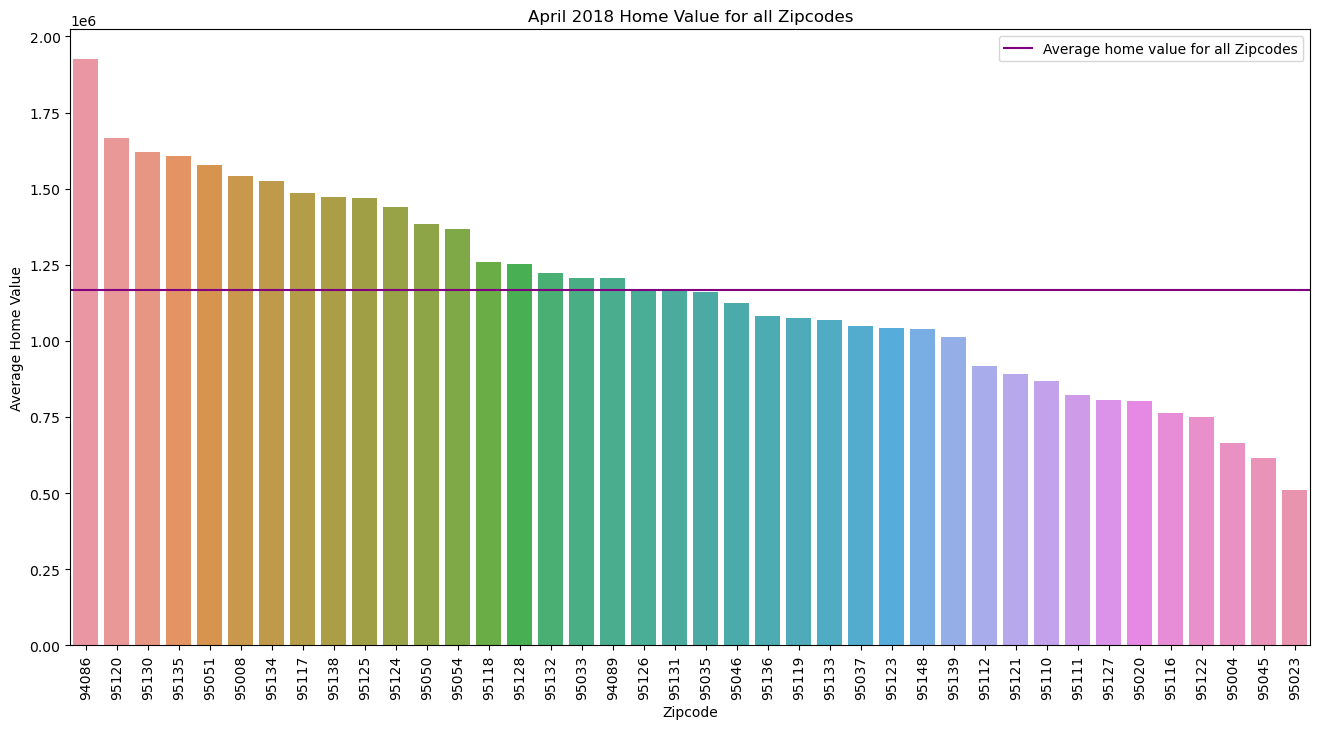

In [22]:
# plot each zipcode by April 2018 avg price
fig, ax = plt.subplots(figsize=(16, 8))
graph = sns.barplot(x='RegionName', y='2018-04', data=san_jose, 
                    order=san_jose.sort_values('2018-04', ascending = False).RegionName, ax=ax)
graph.axhline(san_jose['2018-04'].mean(), color='purple', label='Average home value for all Zipcodes')

ax.set_title('April 2018 Home Value for all Zipcodes')
ax.set_ylabel('Average Home Value')
ax.set_xlabel('Zipcode')
x_labels = [str(a) for a in san_jose.sort_values('2018-04', ascending = False).RegionName]
ax.set_xticklabels(x_labels, rotation = 90)
ax.legend(loc='best');

94086, the second highest performing zipcode in terms of ROI, had the highest average home value. 

### Zipcode price history for all years

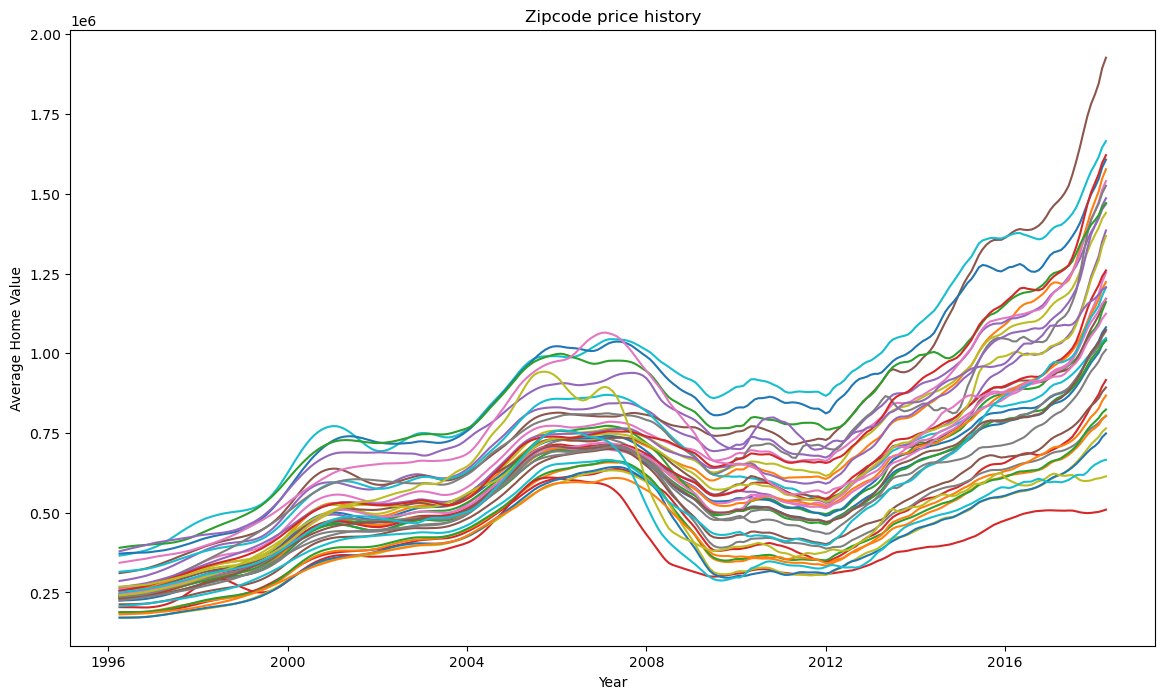

In [23]:
# create dict to store data
zip_dict = {}
    
# make time series dataframe of Zip Code prices
for idx, zipcode in san_jose["RegionName"].iteritems():
    zip_dict[zipcode] = melt_data(san_jose[san_jose['RegionName']==zipcode])
    
# plot zipcode price history
fig,ax = plt.subplots(figsize=(14,8))

for zipcode in zip_dict:
    ax.plot(zip_dict[zipcode]);
ax.set_title('Zipcode price history')
ax.set_ylabel('Average Home Value')
ax.set_xlabel('Year');

Most zipcodes follow a similar trend. The housing market bubble and subsequent crash is clear, with growth beginning again around 2012.

### Zipcode price history since 2012

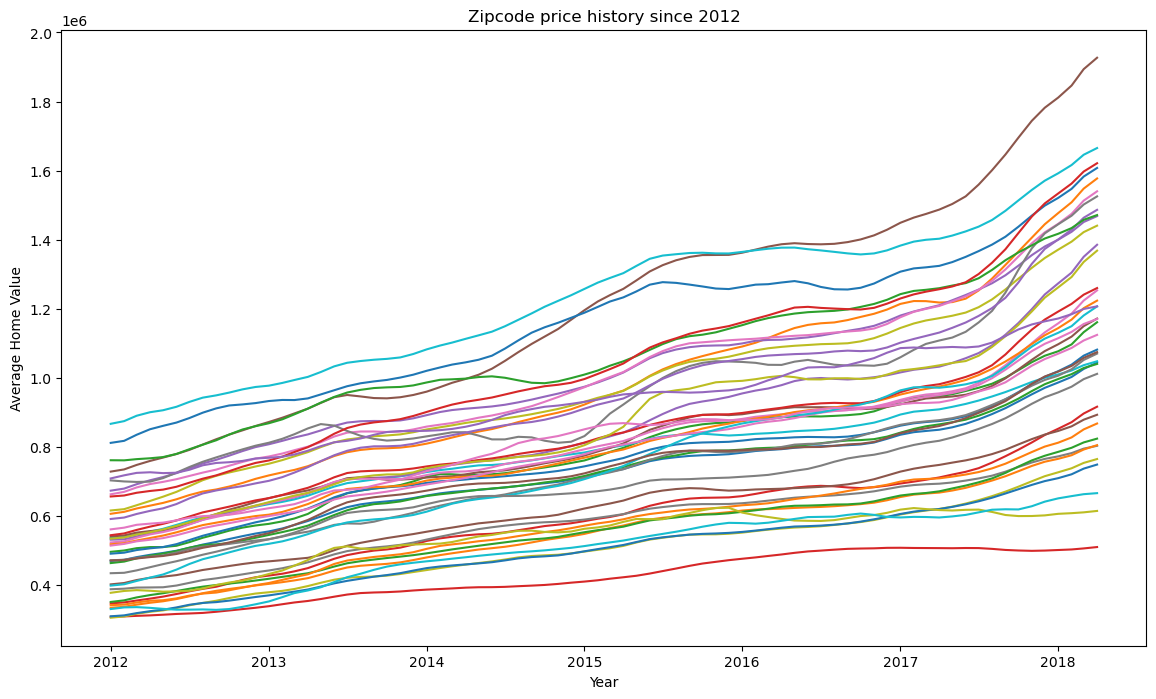

In [24]:
# make time series dataframe of Zip Code prices since 2012
for idx, zipcode in san_jose["RegionName"].iteritems():
    zip_dict[zipcode] = melt_data(san_jose[san_jose['RegionName']==zipcode])['2012-01':]
    
# plot
fig,ax = plt.subplots(figsize=(14,8))

for zipcode in zip_dict:
    ax.plot(zip_dict[zipcode]);
ax.set_title('Zipcode price history since 2012')
ax.set_ylabel('Average Home Value')
ax.set_xlabel('Year');

With the effects of the housing bubble removed, there now appears to be overall steady growth in the area.

# Modeling

The zipcode with the highest 2012-2018 ROI, 94089, was chosen as the zipcode to explore modeling. The last 2 years were witheld from from the training models and used as test data to evaluate model performance. First, an auto-ARIMA was run to generate optimal parameter values for the SARIMA model. The SARIMA model was then used to predict values from the last 2 years, and those predictions were compared with the actual values in order to evaluate how well the model performed. Then, a similar approach was used to run a Prophet model, whose performance was evaluated by comparing predicted prices with the actual observed values. 

For this dataset, the SARIMA model was much higher performing than the Prophet model. 

#### Modeling and evaluation using the highest ROI zipcode, 94089

In [25]:
# df for 94089
zip94089 = san_jose[san_jose['RegionName']==94089]

# time series for 94089
series94089 = melt_data(zip94089)

# remove data from before 2012
recent_94089 = series94089['2012':]
recent_94089

,value
time,
2012-01-01,397900.0
2012-02-01,401800.0
2012-03-01,411400.0
2012-04-01,421100.0
2012-05-01,430100.0
...,...
2017-12-01,1113200.0
2018-01-01,1130100.0
2018-02-01,1149300.0


### Observing trends

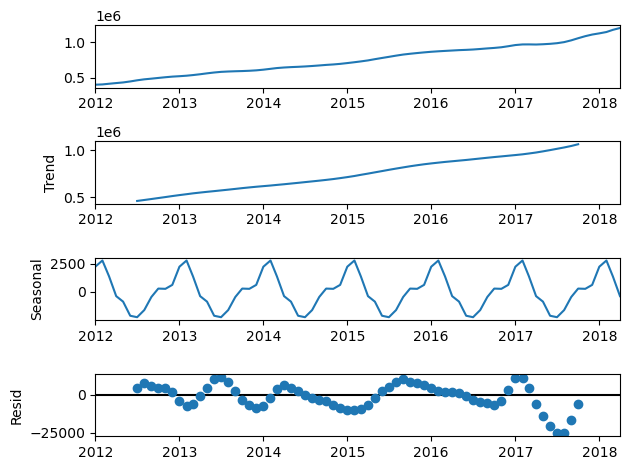

In [26]:
# observe trends
decompose_data = seasonal_decompose(recent_94089, model="additive")
decompose_data.plot();

There is a clear upward trend as well as seasonality in the data. Since I will be using SARIMA and Prophet models, it won't be necessary to remove these trends.

In [27]:
def stationarity_check(TS):
    
    # Perform the Dickey Fuller Test
    dftest = adfuller(TS['value'])
    
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    return dftest[1] < 0.05

In [28]:
stationarity_check(recent_94089)

Results of Dickey-Fuller Test: 

Test Statistic                  1.443749
p-value                         0.997304
#Lags Used                     10.000000
Number of Observations Used    65.000000
Critical Value (1%)            -3.535217
Critical Value (5%)            -2.907154
Critical Value (10%)           -2.591103
dtype: float64


False

If it were necessary to ensure the data was stationary, I would need the p-value to be less than 0.05. I could do so by differencing the data, subtracting the rolling mean, taking the logarithm of the data, or a combination of those.

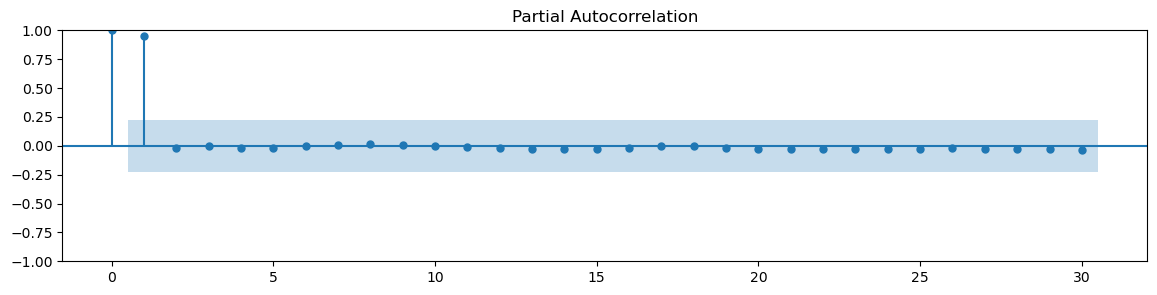

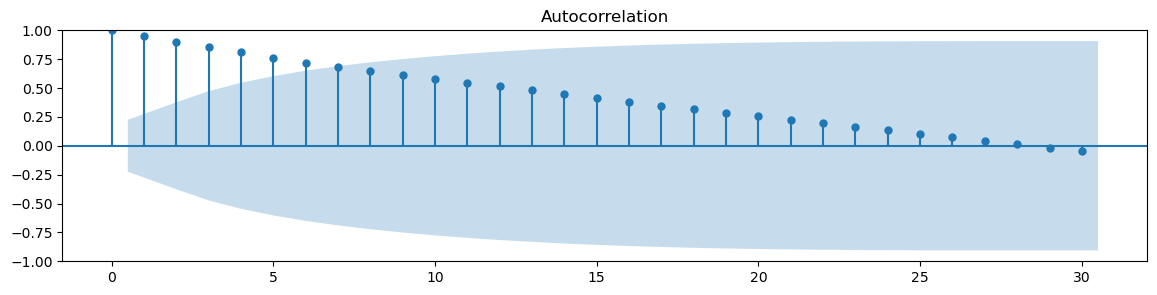

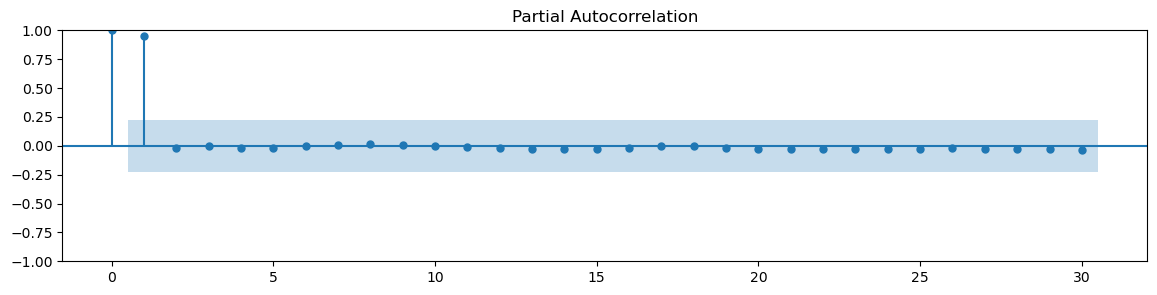

In [29]:
#plot acf and pacf
fig, ax = plt.subplots(figsize=(14,3))
plot_acf(recent_94089, ax=ax, lags=30)

fig, ax = plt.subplots(figsize=(14,3))
plot_pacf(recent_94089, ax=ax, lags=30, method="ywm")

## SARIMA model

First, I am going to examine a SARIMA (Seasonal Autoregressive Integrated Moving Average) model on the zipcode 94089. The SARIMA model takes care of trends and seasonality, so it is not necessary to make the input data stationary. First, an auto ARIMA model was used to generate the optimal p, d, and q values and seasonal order. Those parameters are then used to fit a SARIMA model, which is then used to generate future forecasts.

#### Train-test split

In [30]:
# split the data into a train and test set
train_series = recent_94089[:'2016-04']
test_series = recent_94089['2016-04':]

In [31]:
# run auto arima to find optimal paramers
auto_model = pm.auto_arima(train_series,
                            m=12,
                            seasonal=True,
                            start_p=0,
                            start_q=0,
                            start_P=0,
                            start_Q=0,
                            max_order=6, 
                            test='adf',
                            error_action='warn',  
                            suppress_warnings=True,
                            stepwise=True,
                            trace=False)
                           
print(auto_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   52
Model:               SARIMAX(1, 2, 0)   Log Likelihood                -454.012
Date:                Sun, 29 Oct 2023   AIC                            912.025
Time:                        14:22:43   BIC                            915.849
Sample:                    01-01-2012   HQIC                           913.481
                         - 04-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0200      0.035     -0.566      0.571      -0.089       0.049
sigma2      3.682e+06   6.83e+05      5.392      0.000    2.34e+06    5.02e+06
Ljung-Box (L1) (Q):                  10.68   Jarque-

In [32]:
auto_model.order

(1, 2, 0)

In [33]:
auto_model.seasonal_order

(0, 0, 0, 12)

In [34]:
# input parameters and run sarima model
sarima_model = sm.tsa.statespace.SARIMAX(train_series, 
                                        order=(1,2,0), 
                                        seasonal_order=(0, 0, 0, 12), 
                                        enforce_stationarity=True, 
                                        enforce_invertibility=True)

# Fit the model and print results
output = sarima_model.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0200      0.035     -0.566      0.571      -0.089       0.049
sigma2      3.682e+06   6.83e+05      5.392      0.000    2.34e+06    5.02e+06


C:\Users\lalyn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\lalyn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


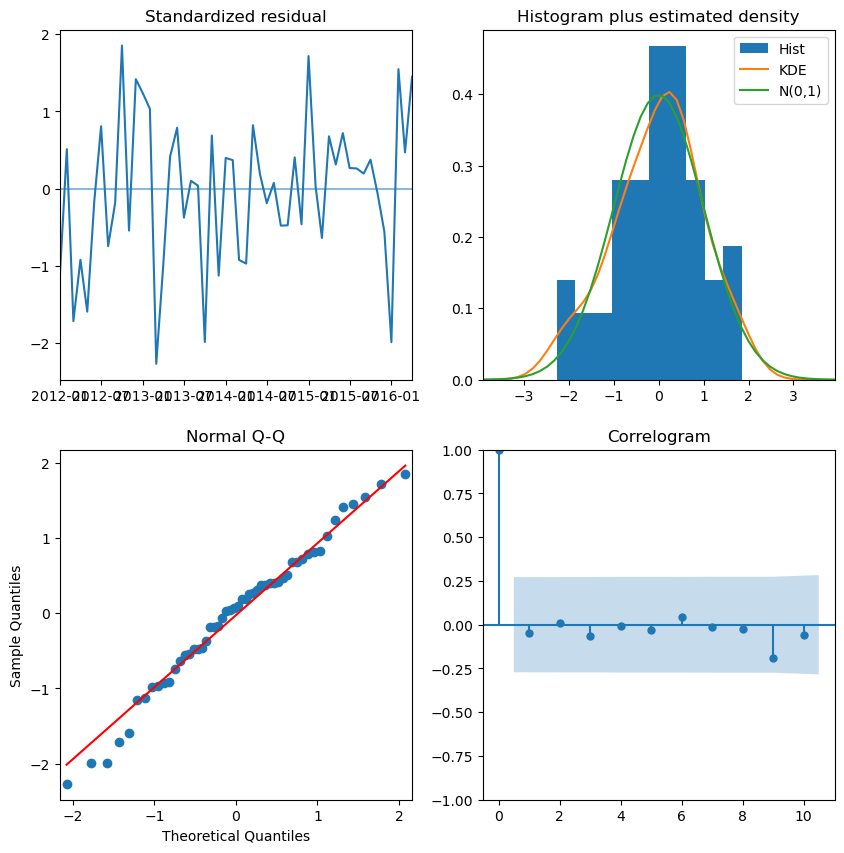

In [55]:
#run model diagnostics to ensure that none of the assumptions made by the model have been violated.
auto_model.plot_diagnostics(figsize=(10,10))
plt.show()


The purpose here is to ensure that residuals remain uncorrelated, normally distributed having zero mean. In the absence of these assumptions, we can not move forward and need further tweaking of the model.

The residuals don't show any obvious seasonality over time (top left). The red KDE line follows closely with the N(0,1) line (where N(0,1) represents a normal distribution with mean 0 and standard deviation of 1), indicating that the residuals are normally distributed (top right). The qq-plot shows that the ordered distribution of residuals follows the linear trend of the samples taken from a standard normal distribution (bottom left). Finally, the autocorrelation (i.e. correlogram) plot shows that the time series residuals have low correlation with lagged versions of itself bottom right.

Thus, this model has no correlations and can be used to forecast future values.

## SARIMA model evaluation 

In [36]:
# use model to predict last 2 years of dataset
pred = output.get_prediction(start=pd.to_datetime('2016-04'), end=pd.to_datetime('2018-04'), dynamic=False)
pred_conf = pred.conf_int()
pred_conf['mean'] = pred.predicted_mean
pred_conf

,lower value,upper value,mean
2016-04-01,881565.095039,8.890869e+05,8.853260e+05
2016-05-01,887237.120693,8.947589e+05,8.909980e+05
2016-06-01,888253.605062,9.049385e+05,8.965960e+05
2016-07-01,888281.541904,9.161066e+05,9.021941e+05
2016-08-01,887464.252691,9.281200e+05,9.077921e+05
2016-09-01,885898.750330,9.408816e+05,9.133902e+05
2016-10-01,883655.270356,9.543211e+05,9.189882e+05
2016-11-01,880787.517682,9.683850e+05,9.245862e+05
2016-12-01,877338.229657,9.830303e+05,9.301843e+05
2017-01-01,873342.446916,9.982222e+05,9.357823e+05


In [37]:
# get rmse
predicted = pred.predicted_mean
real = test_series.value
mse = mean_squared_error(real, predicted)
rmse = math.sqrt(mse)
rmse

73379.14380409155

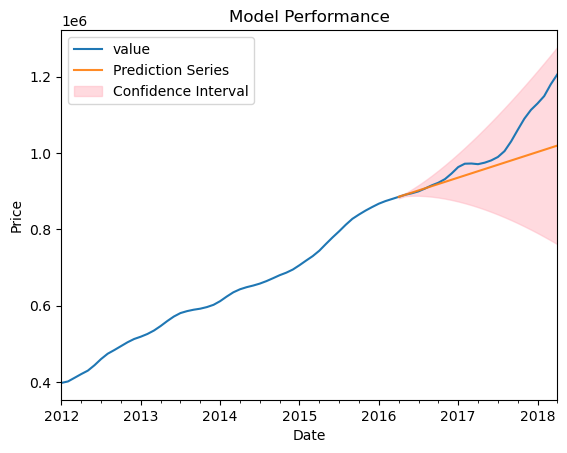

In [38]:
# Plot real vs predicted values along with confidence interval

ax = recent_94089.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Prediction Series', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='lightpink', alpha=0.5,label = 'Confidence Interval')

ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_title('Model Performance')
plt.legend()

plt.show()

## Prophet model

The Prophet model was developed by Facebook to account for datasets often encountered at Facebook, which typically contain any or all of the following- hourly, daily, or weekly observations with at least a few months of history, multiple seasonality trends, holidays, missing observations, large outliers, and non-linear trends. While the dataset used in this project only has a couple of those qualities, it will be interesting to see how it performs.

In [39]:
# copy since the original will be altered
df_pr = recent_94089.copy()
df_pr = recent_94089.reset_index()
 # To use prophet column names must be 'ds' and 'y'
df_pr.columns = ['ds','y']
df_pr

,ds,y
0,2012-01-01,397900.0
1,2012-02-01,401800.0
2,2012-03-01,411400.0
3,2012-04-01,421100.0
4,2012-05-01,430100.0
...,...,...
71,2017-12-01,1113200.0
72,2018-01-01,1130100.0
73,2018-02-01,1149300.0
74,2018-03-01,1180300.0


In [40]:
# split into train and test data
train_data_pr = df_pr.iloc[:len(df)-25]
test_data_pr = df_pr.iloc[len(df)-25:]

# create and fit prophet model
m_prophet = Prophet()
m_prophet.fit(train_data_pr)

14:22:47 - cmdstanpy - INFO - Chain [1] start processing
14:22:48 - cmdstanpy - INFO - Chain [1] done processing


In [41]:
# make dataframe for future values and predict
future = m_prophet.make_future_dataframe(periods=25,freq='MS')
prophet_output = m_prophet.predict(future)

# display predictions
prophet_pred = pd.DataFrame({"Date" : prophet_output[-25:]['ds'], "Pred" : prophet_output[-25:]["yhat"],
                             "Lower" : prophet_output[-25:]['yhat_lower'], "Upper":
                             prophet_output[-25:]['yhat_upper']})
prophet_pred.index.freq = "MS"
prophet_pred

,Date,Pred,Lower,Upper
76,2018-05-01,1.167566e+06,1.151533e+06,1.184363e+06
77,2018-06-01,1.181514e+06,1.163424e+06,1.198773e+06
78,2018-07-01,1.196049e+06,1.179291e+06,1.213925e+06
79,2018-08-01,1.212342e+06,1.195252e+06,1.229457e+06
80,2018-09-01,1.229718e+06,1.212500e+06,1.247817e+06
81,2018-10-01,1.246040e+06,1.228172e+06,1.264837e+06
82,2018-11-01,1.261796e+06,1.242629e+06,1.279761e+06
83,2018-12-01,1.276475e+06,1.256354e+06,1.297074e+06
84,2019-01-01,1.290298e+06,1.268796e+06,1.311861e+06
85,2019-02-01,1.303651e+06,1.282268e+06,1.325801e+06


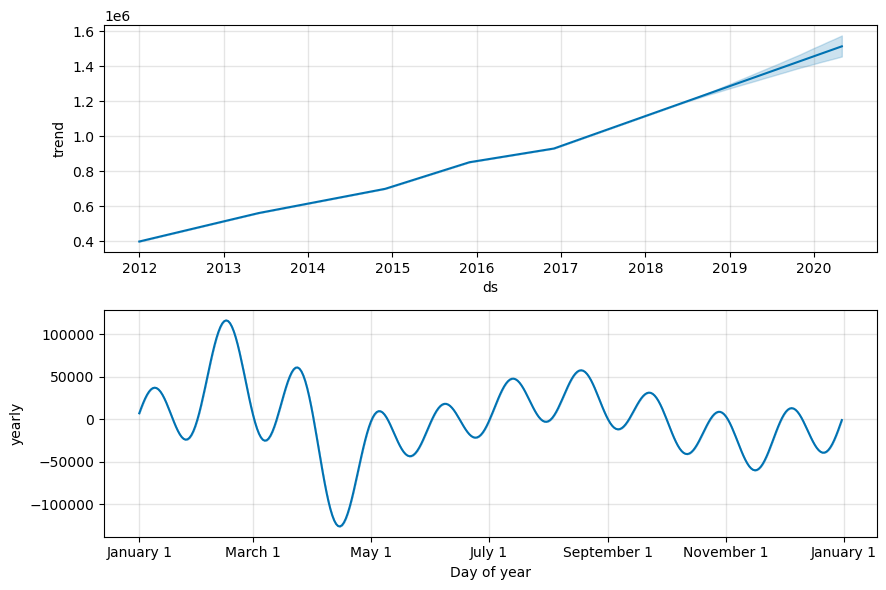

In [43]:
# Plot model components 
m_prophet.plot_components(prophet_output)
plt.show()

Trend looks to play a more important role in the model, but there is clear seasonality as well.

## Evaluation of Prophet model

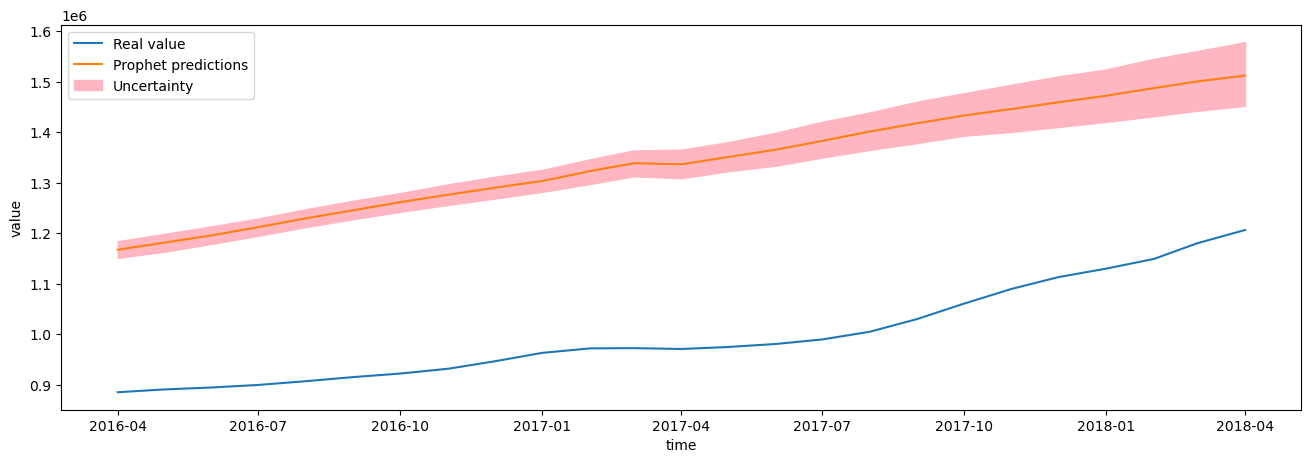

In [44]:
# get prediction values
prophet_preds = prophet_pred['Pred'].values
test_pr = test_series.copy()
test_pr["Prophet_Predictions"] = prophet_pred['Pred'].values

# plot real and predicted values
plt.figure(figsize=(16,5))
ax = sns.lineplot(x= test_pr.index, y=test_pr['value'], label='Real value')
sns.lineplot(x=test_pr.index, y = test_pr["Prophet_Predictions"], label= 'Prophet predictions')
ax.fill_between(x= test_pr.index, y1= prophet_pred['Lower'], y2= prophet_pred['Upper'],color='lightpink',label='Uncertainty')
ax.legend();

In [45]:
# get rmse
predicted_pr = prophet_preds#.predicted_mean
real = test_pr.value
mse = mean_squared_error(real, predicted_pr)
rmse = math.sqrt(mse)
rmse


345769.5991242628

The prophet model performed much poorer on this dataset. Moving forward, I will be using a SARIMA model to forecast future real estate values.

# Forecasting

I will now calculate the 3 year forecast, along with confidence intervals, for zipcode 94089 using the SARIMA model from above. A linnear upward trend is predicted. The confidence interval is relatively narrow for the first year, but widens considerably by the end of the forecast time period. Even if actual values are on the low end of forecast values, these is still growth predicted in the near future. 

In [46]:
# forecast prices for the next 3 years
model = sm.tsa.statespace.SARIMAX(recent_94089, 
                                        order=(1,2,0), 
                                        seasonal_order=(0, 0, 0, 12), 
                                        enforce_stationarity=True, 
                                        enforce_invertibility=True)

# Fit the model and print results
output2 = model.fit()
forecast = output2.get_forecast(36)
future_prediction = forecast.conf_int()
future_prediction['value'] = forecast.predicted_mean
future_prediction.columns = ['lower','upper','prediction'] 
future_prediction

C:\Users\lalyn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\lalyn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


,lower,upper,prediction
2018-05-01,1.226716e+06,1.239217e+06,1.232966e+06
2018-06-01,1.245434e+06,1.273230e+06,1.259332e+06
2018-07-01,1.262497e+06,1.308898e+06,1.285697e+06
2018-08-01,1.278146e+06,1.345980e+06,1.312063e+06
2018-09-01,1.292544e+06,1.384313e+06,1.338428e+06
2018-10-01,1.305807e+06,1.423781e+06,1.364794e+06
2018-11-01,1.318027e+06,1.464292e+06,1.391159e+06
2018-12-01,1.329274e+06,1.505776e+06,1.417525e+06
2019-01-01,1.339607e+06,1.548174e+06,1.443891e+06
2019-02-01,1.349076e+06,1.591437e+06,1.470256e+06


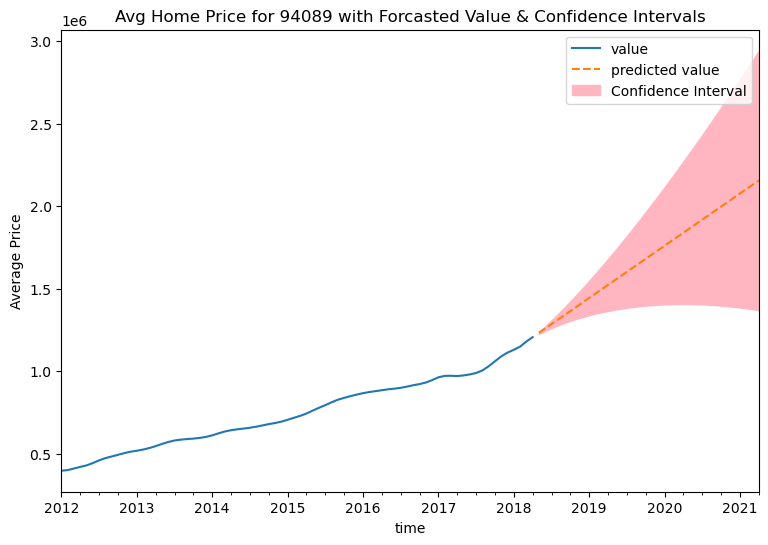

In [57]:
#Plotting the Forecast with confidence interval

fig, ax = plt.subplots(figsize=(9,6))
recent_94089.plot(ax=ax,label='Real Values')
future_prediction['prediction'].plot(ax=ax,label='predicted value',ls='--')

ax.fill_between(x= future_prediction.index, y1= future_prediction['lower'], 
                y2= future_prediction['upper'],color='lightpink',
                label='Confidence Interval')
ax.legend() 
plt.ylabel("Average Price")
plt.title('Avg Home Price for 94089 with Forcasted Value & Confidence Intervals')
plt.show()

# Forecasting on all relevant zipcodes

Using the SARIMA model that was used to predict and forecast future values for 94089 on all relevant zipcodes. The zipcode and corresponding forecasted 3 year ROI were stored in a list, which was sorted and used to make conclusions.

In [48]:
# list to store results
results = []

for idx, zipcode in san_jose["RegionName"].iteritems():
    
    # reshape and slice the time series 
    series = melt_data(san_jose[san_jose['RegionName']== zipcode])
    recent_series = series['2012':]
    
    # Split into train and test set
    train_series = recent_series[:'2016-04']
    test_series = recent_series['2016-04':]
    
    #Auto ARIMA model to find optimal parameters
    auto_model = pm.auto_arima(train_series,
                            m=12,
                            seasonal=True,
                            start_p=0,
                            start_q=0,
                            start_P=0,
                            start_Q=0,
                            max_order=6, 
                            test='adf',
                            error_action='ignore',  
                            suppress_warnings=True,
                            stepwise=True,
                            trace=False)
   
    # Plug the optimal parameter values into a SARIMAX model and fit the series
    sarima_model = sm.tsa.statespace.SARIMAX(recent_series, 
                                            order= auto_model.order, 
                                            seasonal_order= auto_model.seasonal_order)

    output = sarima_model.fit()

    ## forecast the next 3 years 
    forecast = output.get_forecast(36)
    prediction = forecast.conf_int()
    prediction['value'] = forecast.predicted_mean
    prediction.columns = ['lower','upper','prediction'] 
    
    #calculate the Zipcode's 3 year ROI and add to results
    three_year_ROI = ((prediction['prediction'][-1] - series['value'][-1]) / series['value'][-1]) * 100
    
    results.append([zipcode, three_year_ROI])

C:\Users\lalyn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\lalyn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\lalyn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\lalyn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\lalyn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

C:\Users\lalyn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\lalyn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\lalyn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\lalyn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\lalyn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

In [49]:
# make dataframe of results
results = pd.DataFrame(results, columns=('Zipcode', '3yrROI'))
results

,Zipcode,3yrROI
0,95123,63.707964
1,95051,67.110519
2,95035,0.000000
3,95112,0.000000
4,95125,42.244734
5,94086,61.843471
6,95008,63.136495
7,95020,0.000000
8,95124,47.047062
9,95037,0.000000


In [50]:
# take the top 5 zipcodes
top_5_zipcodes = results.sort_values(by='3yrROI', ascending=False)[:5]
top_5_zipcodes

,Zipcode,3yrROI
14,95050,91.132032
28,95054,86.052632
16,95128,85.406218
29,94089,78.663960
15,95126,68.176538


# Recommendations

The zipcodes forecasted to have the highest ROI in the next 3 years are 95050, 95054, 95128, 94089, and 95126. Forecasted 3 year ROI for the top 5 zipcodes range between 68% and 92%. All 5 zipcodes had an average 2018 home value between roughly \\$1.2 and \\$1.4 million. Although Santa Clara only had 3 zipcodes represented, 2 of them were in the top 5, indicating considerable growth in that city. 

In [51]:
results['3yrROI'].describe()

count    40.000000
mean     34.238086
std      31.470451
min     -19.031719
25%       0.000000
50%      41.549107
75%      56.378713
max      91.132032
Name: 3yrROI, dtype: float64

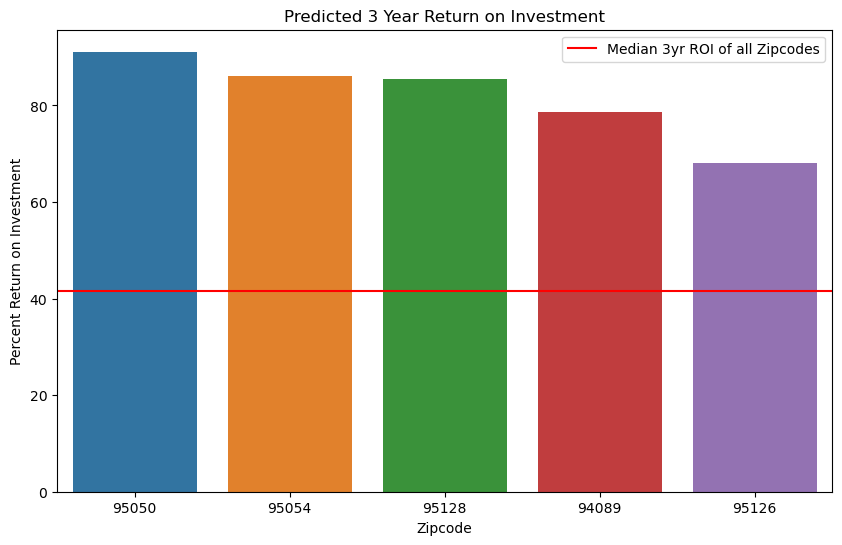

In [52]:
# plot ROI of top 5 zipcodes
fig, ax = plt.subplots(figsize=(10, 6))
graph = sns.barplot(x='Zipcode', y='3yrROI', data= top_5_zipcodes,
                    order=top_5_zipcodes.sort_values('3yrROI',ascending = False).Zipcode, ax=ax)
graph.axhline(results['3yrROI'].median(), color='red', label='Median 3yr ROI of all Zipcodes')
ax.set_title('Predicted 3 Year Return on Investment')
ax.set_ylabel('Percent Return on Investment')
ax.legend();

Shown is the predicted 3 year ROI for the top 5 zipcodes, which ranges from 68% to 91% forcasted growth. This is substantially higher than the median (41%) and mean (34%). 

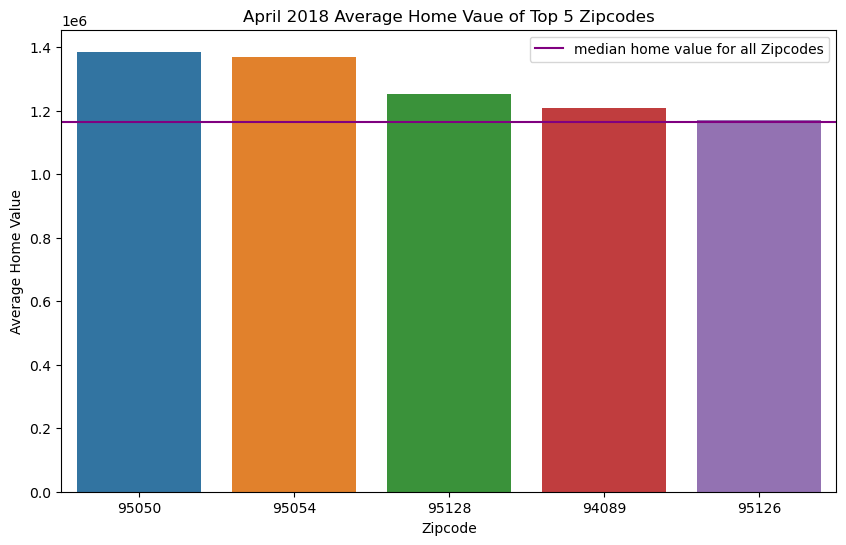

In [58]:
# create dataframe that includes top 5 zipcodes with their April 2018 prices
zips = top_5_zipcodes['Zipcode']
zips.reset_index()
sjc = san_jose.loc[san_jose['RegionName'].isin(zips)]
full = sjc.merge(top_5_zipcodes, how='left', left_on='RegionName', right_on='Zipcode')
final = full.sort_values('3yrROI', ascending=False)
final

# plot April 2018 price of top 5 zipcodes
fig, ax = plt.subplots(figsize=(10, 6))
graph = sns.barplot(x=final['Zipcode'], y=final['2018-04'],
                    order=top_5_zipcodes.sort_values('3yrROI',ascending = False).Zipcode, ax=ax)
graph.axhline(san_jose['2018-04'].median(), color='purple', label='median home value for all Zipcodes')
ax.set_title('April 2018 Average Home Vaue of Top 5 Zipcodes')
ax.set_ylabel('Average Home Value')
ax.set_xlabel('Zipcode')
ax.legend(loc='best');

All 5 of the zipcodes fall at or slightly above the median price range for 2018. Thus, locations with neither high or low values were forecasted to grow as much.

# Conclusions

Given the growth the area has seen in the last decade, any of the above 5 zipcodes would be a good investment choice. A brief summary about each zipcode is provided below. Statistics sourced from https://www.zipdatamaps.com/   

## Zipcode 95050:
- Predicted to grow by 91%
- Santa Clara, CA
- population of 40,000 
- 14,000 households

## Zipcode 95054:
- Predicted to grow by 86%
- Santa Clara, CA
- population of 24,000
- 8,000 households

## Zipcode 95128:
- Predicted to grow by 85%
- San Jose, CA
- population of 35,000
- 13,800 households

## Zipcode 94089:
- Predicted to grow by 78%
- Sunnyvale, CA
- population of 24,000
- 7,500 households

## Zipcode 95126:
- Predicted to grow by 68%
- San Jose, CA
- population of 35,000
- 13,200 households


## Map of top 5 zipcodes

Lattitude and longitude for each zipcode sourced from https://www.latlong.net/

In [54]:
# get lat and long of zipcodes
recommended_zips = top_5_zipcodes.drop('3yrROI', axis=1)
recommended_zips['latitude'] = [37.346990, 37.393940, 37.316080, 37.403020, 37.3290]
recommended_zips['longitude'] = [-121.955640, -121.960080, -121.937150, -122.010820, -121.9160]
recommended_zips.columns = ['ZipCode','Latitude','Longitude']

import folium
#create map
m = folium.Map(
    location=[37.3000,-121.9500],
    width='75%',
    length='75%',
    zoom_start=9.5
)

# add markers for each location
for a in list(range(len(recommended_zips))):
    
    folium.Circle(
    radius=1000,
    location=[recommended_zips[['Latitude','Longitude']].iloc[a][0],recommended_zips[['Latitude','Longitude']].iloc[a][1]],
    popup="The Waterfront",
    color="crimson",
    fill=True,
    ).add_to(m);

m


# Next Steps and Limitations:

- Economic recessions are hard to predict and can have drastic influences on real estate prices. 


- Other factors that contribute to housing demand- work-from-home opportunities, a booming start-up, job markets, and weather.


- The Zillow dataset had its most recent observations from April 2018. Finding more recent data will allow for more accurately forecasting future home values in the next few years.

# For More Information

See the full analysis in the [Jupyter Notebook](https://github.com/lalynjay/Time_series_analysis/blob/main/Time_series_analysis.ipynb) or review [this presentation](https://github.com/lalynjay/weather_classification/blob/main/weather_classification.pdf)

For additional info, contact Lynn Anderson at lalynjay@gmail.com

Repository Structure

├── data 

├── images

├── README.md

├── ts_presentation.pdf

└── notebook.ipynb